# 自动微分

对于复杂的模型，手工进行更新是一件很痛苦的事情。

深度学习框架通过自动计算导数，即自动微分（automatic differentiation）来加快求导。实际中，根据我们设计的模型，系统会构建一个计算图（computational graph），来跟踪计算是哪些数据通过哪些操作组合起来产生输出。自动微分使系统能够随后反向传播梯度。 这里，反向传播（backpropagate）意味着跟踪整个计算图，填充关于每个参数的偏导数。

## 标量函数的梯度

例如要对函数 $y = 2 \mathbf{x}^T \mathbf{x}$ 的梯度。

首先，我们创建变量：向量 $\mathbf{x}$：

In [1]:
import torch

x = torch.arange(4.0)
x

tensor([0., 1., 2., 3.])

在进行实际计算前，我们需要明确一点：我们不可能为每个更新过后的梯度一只分配新的内存空间。而 Pytorch 中设定自动更新向量（并自动积累保存）所需的梯度空间很简单：

In [4]:
x.requires_grad_(True) # 上面的加上这句可以简写为：x = torch.arange(4.0, requires_grad=True)
x, x.grad

(tensor([0., 1., 2., 3.], requires_grad=True), None)

可以看到，当前 $\mathbf{x}$ 的梯度还是 None。现在我们创建函数 $y$：

In [5]:
y = 2 * torch.dot(x, x)
y

tensor(28., grad_fn=<MulBackward0>)

可以看到，$y$ 自动识别并且变成了一个可以计算梯度的函数。而且对于向量 $\mathbf{x}$ 的值计算出了函数值。下面我们通过反向传播计算梯度：

In [6]:
y.backward()
x.grad

tensor([ 0.,  4.,  8., 12.])

通过简单计算，他的结果是正确的。但是可以计算一下，因为计算易知梯度的表达式是 $4 \mathbf{x}$：

In [7]:
x.grad == 4 * x

tensor([True, True, True, True])

再来计算另一个函数 $y = \sum_{i=0}^{4} x_i$ 的梯度：

In [8]:
x.grad.zero_() # 首先需要清除之前的值，因为 Pytorch 会自动积累梯度
y = x.sum()
y.backward()
x.grad

tensor([1., 1., 1., 1.])

## 非标量函数的反向传播

就是最优化里面学过的向量值函数。

当y不是标量时，向量y关于向量x的导数的最自然解释是一个矩阵:

$$
\left[\begin{array}{cccc}
\frac{\partial g_1\left(x_0\right)}{\partial x_1} & \frac{\partial g_2\left(x_0\right)}{\partial x_1} & \ldots & \frac{\partial g_{n 1}\left(x_0\right)}{\partial x_1} \\
\frac{\partial g_1\left(x_0\right)}{\partial x_2} & \frac{\partial g_2\left(x_0\right)}{\partial x_2} & \ldots & \frac{\partial g_n\left(x_0\right)}{\partial x_2} \\
\vdots & \vdots & & \vdots \\
\frac{\partial g_1\left(x_0\right)}{\partial x_n} & \frac{\partial g_2\left(x_0\right)}{\partial x_n} & \ldots & \frac{\partial g_m\left(x_0\right)}{\partial x_n}
\end{array}\right]
$$

对于高阶和高维的y和x，求导的结果可以是一个高阶张量。

然而，虽然这些更奇特的对象确实出现在高级机器学习中（包括深度学习中），但当我们调用向量的反向计算时，我们通常会试图计算一批训练样本中每个组成部分的损失函数的导数。 这里，我们的目的不是计算微分矩阵，而是单独计算批量中每个样本的偏导数之和（也就是上面矩阵**每一列的和**的值算出来作为一个向量，然后作为x的梯度）

In [16]:
x.grad.zero_()
y = x * x
# 等价于y.backward(torch.ones(len(x)))
y.sum().backward() # 但这个式子更能表达其数学含义（先把 y 的分量加在一起，在作为整体求梯度）
x.grad, x.grad == 2 * x

(tensor([0., 2., 4., 6.]), tensor([True, True, True, True]))

## 分离计算

有时，我们希望将某些计算移动到记录的计算图之外。例如，假设 $y$ 是作为 $x$ 的函数计算的，而 $z$ 则是作为 $y$ 和 $x$ 的函数计算的。想象一下，我们想计算 $z$ 关于 $x$ 的梯度，但由于某种原因，我们希望将 $y$ 视为一个常数，并且只考虑到 $x$ 在 $y$ 被计算后发挥的作用。

在这里，我们可以分离 $y$ 来返回一个新变量 $u$，该变量与 $y$ 具有相同的值，但丢弃计算图中如何计算 $y$ 的任何信息。换句话说，梯度不会向后流经 $u$ 到 $x$。 因此，下面的反向传播函数计算 $z=ux$ 关于 ${x}$ 的偏导数同时将 $u$ 作为常数处理，而不是 $z=x*x*x$ 关于 $x$ 的偏导数。

> 这里的 `*` 表示逐个乘法

In [15]:
x.grad.zero_()
y = x * x
u = y.detach()
z = u * x

z.sum().backward()
x.grad == u

tensor([True, True, True, True])

可以看出来，由于把 u 作为常数进行计算，所以 z 对 x 求梯度及如果就是 u

## Python 控制流的梯度计算

使用自动微分的一个好处是：即使构建函数的计算图需要通过Python控制流（例如，条件、循环或任意函数调用），我们仍然可以计算得到的变量的梯度。在下面的代码中，while 循环的迭代次数和 if 语句的结果都取决于输入 a 的值：

In [22]:
def f(a):
    b = a * 2
    while b.norm() < 1000:
        b *= 2
    
    if b.sum() > 0:
        c = b
    else:
        c = b * 1000
        
    return c

In [23]:
a = torch.randn(size=(), requires_grad=True)
d = f(a)
d.backward()

a.grad == d / a # 这个只对 x 是标量（单个数）的时候生效

tensor(True)

上面的例子中，不管函数 $f(x)$ 内部对输入的向量 $\mathbf{a}$ 经过如何处理，$\mathbf{c}$ 最后都会是这样一个形式：$C \mathbf{a}$ 也就是一个常数乘上 $\mathbf{x}$。所以对其求梯度再逐元素相除，得到的就是这个常数，也是梯度

## 练习

### 2

In [4]:
import torch

aa = torch.arange(4.0, requires_grad=True)
bb = torch.dot(aa, aa)

bb.backward()
print(aa.grad)
bb.backward()
print(aa.grad)

tensor([0., 2., 4., 6.])


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

### 3

In [20]:
def function(a):
    b = a * 2
    while b.norm() < 1000:
        b *= 2
    
    if b.sum() > 0:
        c = b
    else:
        c = b * 1000
        
    return c

aaa = torch.rand((2, 2), requires_grad=True)
bbb = function(aaa)

bbb.sum().backward()
aaa.grad == bbb / aaa

tensor([[True, True],
        [True, True]])

### 5（重要）

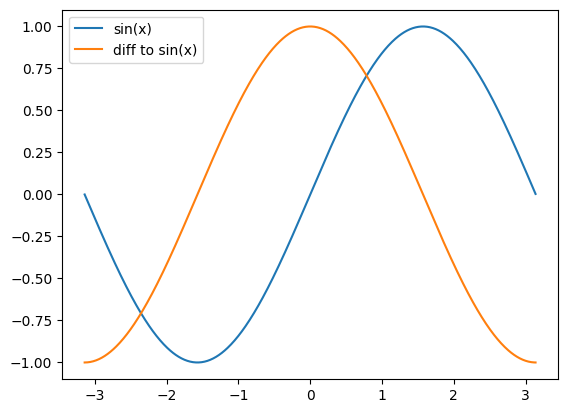

In [37]:
import math
import matplotlib.pyplot as plt

def func(x):
    return torch.sin(x)

x_num = torch.arange(-torch.pi, torch.pi, 0.01, requires_grad=True)
func_num = func(x_num)
func_num.sum().backward()

x_show = x_num.detach()

plt.plot(x_show, func_num.detach(), label='sin(x)')
plt.plot(x_show, x_num.grad.detach(), label='diff to sin(x)')
plt.legend()
plt.show()